## Imports

In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

import numpy as np
import matplotlib.pyplot as plt
import time
import os

## Load data

In [2]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
# load mnist dataset
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11493376/11490434 [==============================] - 2s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


## Preview digits

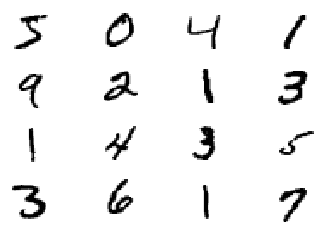

In [3]:
# plot images from the training dataset
for i in range(16):
	# define subplot
	plt.subplot(4, 4, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

## Define the Discriminator

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_____________________________________

### Prepare data for training

In [5]:
def convert_trainX(trainX):
	# expand to 3d, e.g. add channels dimension
	X = np.expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

dataset = convert_trainX(trainX)
dataset.shape

(60000, 28, 28, 1)

### Define methods for generating:
- real samples (just sample from the dataset)
- random fake samples - all the values are random and they represent noise

In [0]:
# select real samples + their labels: 1 for REAL as 0 represents FAKE
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

### Train the Discriminator on real + randomly generated images

In [7]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
  
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model, dataset, n_iter=50)









>1 real=36% fake=62%
>2 real=40% fake=77%
>3 real=40% fake=91%
>4 real=42% fake=97%
>5 real=41% fake=99%
>6 real=39% fake=99%
>7 real=47% fake=100%
>8 real=37% fake=99%
>9 real=42% fake=100%
>10 real=46% fake=100%
>11 real=48% fake=100%
>12 real=45% fake=100%
>13 real=55% fake=100%
>14 real=58% fake=100%
>15 real=66% fake=100%
>16 real=63% fake=100%
>17 real=59% fake=100%
>18 real=62% fake=100%
>19 real=66% fake=100%
>20 real=77% fake=100%
>21 real=82% fake=100%
>22 real=77% fake=100%
>23 real=81% fake=100%
>24 real=88% fake=100%
>25 real=87% fake=100%
>26 real=90% fake=100%
>27 real=88% fake=100%
>28 real=94% fake=100%
>29 real=95% fake=100%
>30 real=96% fake=100%
>31 real=95% fake=100%
>32 real=98% fake=100%
>33 real=98% fake=100%
>34 real=99% fake=100%
>35 real=99% fake=100%
>36 real=98% fake=100%
>37 real=99% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=99% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% 

### Define the Generator

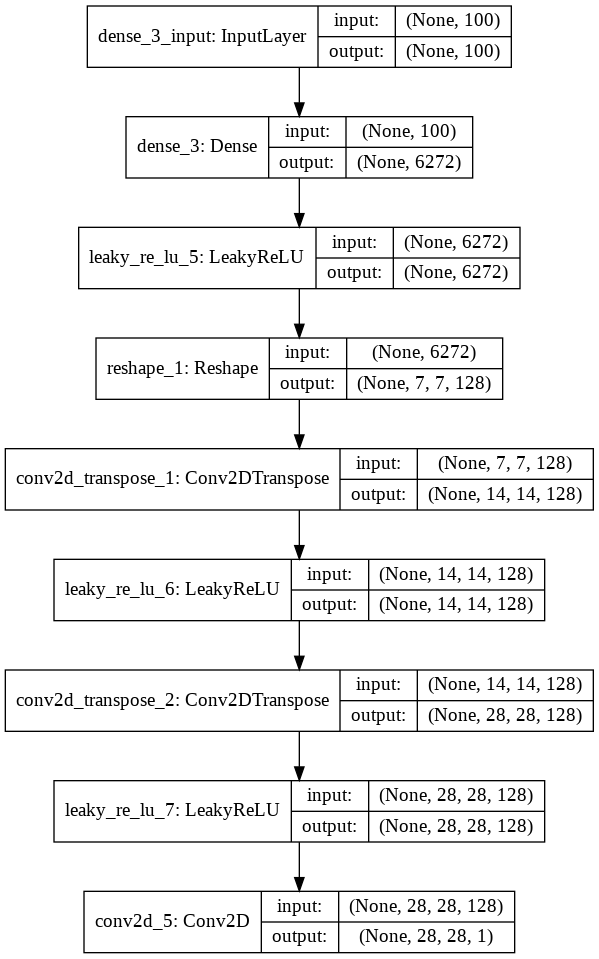

In [8]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

### Define methods for generating:
- latent points for the generator
- fake samples using the generator model

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_with_generator(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

### Preview what the Generator generates without training

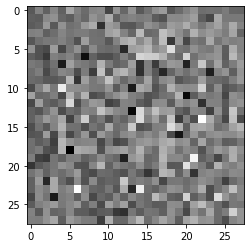

In [10]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 16
X, _ = generate_fake_samples_with_generator(model, latent_dim, n_samples)
i = 1
plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

### Define the generator+discriminator model that will update generator's weights
- the generator's aim is to produce fake samples that look like real samples
- backpropagation will not modify discriminator's weights

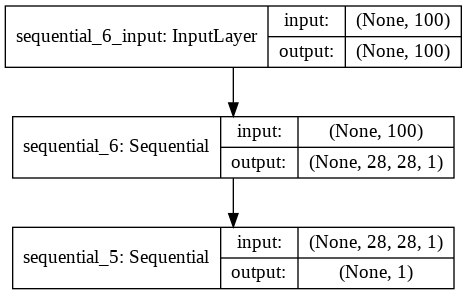

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

### Define the `train` method for both generator and discriminator
1. Train discriminator on 50% real samples (from the dataset) and 50% fake samples generated by the generator
2. Train generator as follows:
  - feed latent points into the generator
  - take generator's output and input to the discriminator
  - compute discriminator's loss when all generated samples' labels were '1' ("REAL")
  - update generator's weights accordingly
    - discriminator outputs 0.25: bigger penalty (poor 'fake' sample)
    - discriminator outputs 0.9: smaller penalty (good 'fake' sample)

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, save_every=10):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  acc_real_list, acc_fake_list = [], []
  loss_real_list, loss_fake_list = [], []

  timestamp = timestr = time.strftime("%Y-%m-%d_%H:%M:%S")
  if not os.path.isdir(timestamp):
    os.mkdir(timestamp)
  print(f">>> MODEL AND ITS EVALUATION CAN BE FOUND IN {timestamp} DIRECTORY :)")

  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples_with_generator(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      # train distriminator with 50% fake examples and 50% real examples
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      # summarize loss on this batch
      # print('\t >%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

    # EVALUATION
    n_samples = 64
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    loss_real, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    acc_real_list.append(acc_real); loss_real_list.append(loss_real)

    # prepare fake examples
    x_fake, y_fake = generate_fake_samples_with_generator(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    acc_fake_list.append(acc_fake); loss_fake_list.append(loss_fake)

    print('\n> %d, real_acc=%.3f, fake_acc=%.3f' % (i+1, acc_real, acc_fake))
    print('> %d, real_loss=%.3f, fake_loss=%.3f\n' % (i+1, loss_real, loss_fake))

    if (i+1) % save_every == 0:
      print()
      # save generating images result
      save_images_plot(x_fake, i, timestamp=timestamp, n=8)

      # save plot with accuracy
      save_measure_plot(acc_real_list, acc_fake_list, i, label='accuracy', timestamp=timestamp)

      # save plot with loss
      save_measure_plot(loss_real_list, loss_fake_list, i, label='loss', timestamp=timestamp)

      # save model
      save_model(g_model, i, timestamp=timestamp)

In [0]:
def save_measure_plot(real_list, fake_list, epoch, label='accuracy', timestamp=''):
  print("[ ] Creating plots for %s, epoch %d..." % (label, epoch+1))
  filename = '%s_%s_plot_e%03d.png' % (timestamp, label, epoch+1)
  plt.figure(figsize=(14, 8))

  # plt.subplot(121)
  plt.plot([i for i in range(len(real_list))], real_list, label=f"real {label}")

  # plt.subplot(122)
  plt.plot([i for i in range(len(fake_list))], fake_list, label=f"fake {label}")
  plt.title("real / fake %s" % (label))
  
  plt.legend(loc="best")
  plt.savefig(os.path.join(timestamp, filename))
  plt.close()

In [0]:
# create and save a plot of generated images (reversed grayscale)
def save_images_plot(examples, epoch, n=4, timestamp=''):
	print("[ ] Creating images preview of %d examples, epoch %d..." % (n*n, epoch+1))
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = '%s_generated_plot_e%03d.png' % (timestamp, epoch+1)
	plt.savefig(os.path.join(timestamp, filename))
	plt.close()

In [0]:
def save_model(g_model, epoch, timestamp=''):
  if not os.path.isdir(os.path.join(timestamp, 'model')):
    os.mkdir(os.path.join(timestamp, 'model'))
  filename = os.path.join(timestamp, 'model', 'generator_%03d.h5' % (epoch + 1))
  g_model.save(filename)

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, save_every=20)

>>> MODEL AND ITS EVALUATION CAN BE FOUND IN 2019-12-09_21:13:43 DIRECTORY :)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



> 1, real_acc=0.359, fake_acc=1.000
> 1, real_loss=0.746, fake_loss=0.486

